# Molecular Solublity Prediction Though Graph Neural Networks

# Analysis


In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from collections import Counter

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 60)
print("ESOL DATASET ANALYSIS - PyTorch Geometric MoleculeNet")
print("=" * 60)




/Users/ashi/Desktop/SOLGNN/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ESOL DATASET ANALYSIS - PyTorch Geometric MoleculeNet


In [3]:
dataset = MoleculeNet(root=".",name="ESOL")

print(f"\n{'='*50}")
print("DATASET OVERVIEW")
print(f"{'='*50}")
print(f"Dataset: {dataset}")
print(f"Number of molecules: {len(dataset)}")
print(f"Number of features per node: {dataset.num_node_features}")
print(f"Number of features per edge: {dataset.num_edge_features}")
print(f"Number of tasks (targets): {dataset.num_tasks if hasattr(dataset, 'num_tasks') else 1}")



# Examine first molecule
print(f"\n{'='*50}")
print("FIRST MOLECULE STRUCTURE")
print(f"{'='*50}")
data = dataset[0]
print(f"Data object: {data}")
print(f"Node features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge attributes shape: {data.edge_attr.shape if data.edge_attr is not None else 'None'}")
print(f"Target (Log Solubility): {data.y.item():.4f}")
print(f"SMILES: {data.smiles if hasattr(data, 'smiles') else 'Not available'}")


DATASET OVERVIEW
Dataset: ESOL(1128)
Number of molecules: 1128
Number of features per node: 9
Number of features per edge: 3
Number of tasks (targets): 1

FIRST MOLECULE STRUCTURE
Data object: Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Node features shape: torch.Size([32, 9])
Edge index shape: torch.Size([2, 68])
Edge attributes shape: torch.Size([68, 3])
Target (Log Solubility): -0.7700
SMILES: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


In [4]:
# Extract all targets solubility values and graph properties
solubility_values = []
num_nodes_list = []
num_edges_list = []
smiles_list = []

for i, mol in enumerate(dataset):
    solubility_values.append(mol.y.item())
    num_nodes_list.append(mol.x.shape[0])
    num_edges_list.append(mol.edge_index.shape[1])
    if hasattr(mol, 'smiles'):
        smiles_list.append(mol.smiles)

df = pd.DataFrame({
    'Solubility (log mol/L)': solubility_values,
    'Num Atoms': num_nodes_list,
    'Num Bonds': num_edges_list
})

if smiles_list:
    df['SMILES'] = smiles_list

print(f"\n{'='*50}")
print("EXTRACTED DATA SUMMARY")
print(f"{'='*50}")
print(df.describe())


EXTRACTED DATA SUMMARY
       Solubility (log mol/L)    Num Atoms    Num Bonds
count             1128.000000  1128.000000  1128.000000
mean                -3.050102    13.289894    27.354610
std                  2.096441     6.878603    15.852082
min                -11.600000     1.000000     0.000000
25%                 -4.317500     8.000000    16.000000
50%                 -2.860000    12.000000    24.000000
75%                 -1.600000    18.000000    38.000000
max                  1.580000    55.000000   124.000000


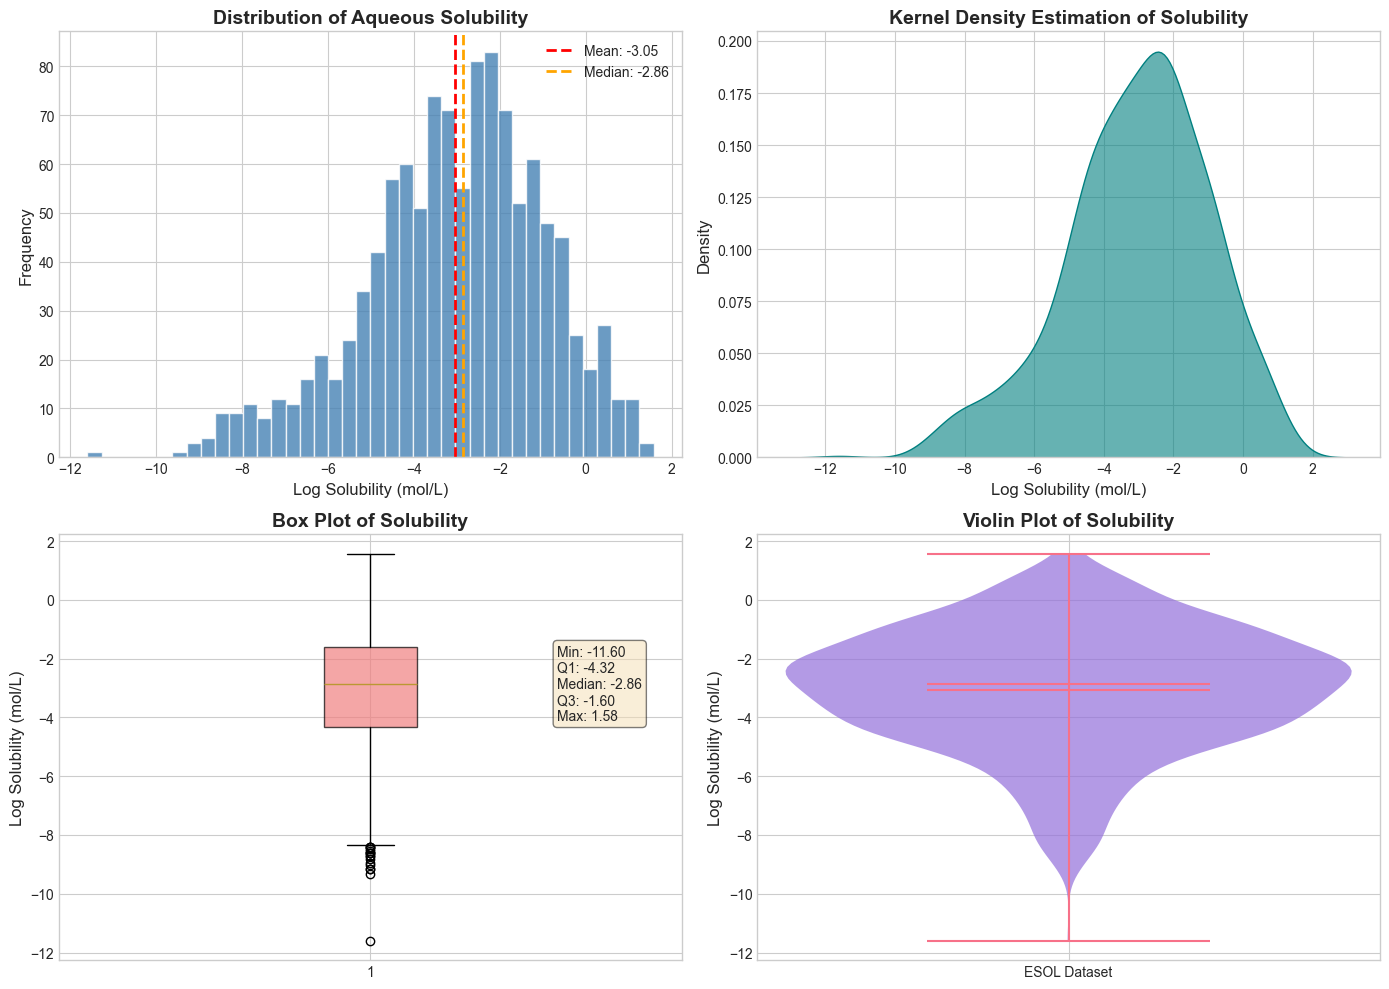

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram for Solubility
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(df['Solubility (log mol/L)'], bins=40, 
                             color='steelblue', edgecolor='white', alpha=0.8)
ax1.axvline(df['Solubility (log mol/L)'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {df["Solubility (log mol/L)"].mean():.2f}')
ax1.axvline(df['Solubility (log mol/L)'].median(), color='orange', 
            linestyle='--', linewidth=2, label=f'Median: {df["Solubility (log mol/L)"].median():.2f}')
ax1.set_xlabel('Log Solubility (mol/L)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Aqueous Solubility', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)

# 2. KDE Plot
ax2 = axes[0, 1]
sns.kdeplot(data=df, x='Solubility (log mol/L)', ax=ax2, fill=True, color='teal', alpha=0.6)
ax2.set_xlabel('Log Solubility (mol/L)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Kernel Density Estimation of Solubility', fontsize=14, fontweight='bold')

# 3. Box Plot
ax3 = axes[1, 0]
bp = ax3.boxplot(df['Solubility (log mol/L)'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][0].set_alpha(0.7)
ax3.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax3.set_title('Box Plot of Solubility', fontsize=14, fontweight='bold')

# Add statistics as text
stats_text = f"Min: {df['Solubility (log mol/L)'].min():.2f}\n"
stats_text += f"Q1: {df['Solubility (log mol/L)'].quantile(0.25):.2f}\n"
stats_text += f"Median: {df['Solubility (log mol/L)'].median():.2f}\n"
stats_text += f"Q3: {df['Solubility (log mol/L)'].quantile(0.75):.2f}\n"
stats_text += f"Max: {df['Solubility (log mol/L)'].max():.2f}"
ax3.text(1.3, df['Solubility (log mol/L)'].median(), stats_text, fontsize=10, 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Violin plot: Bonds by Category (Don't know what this does , but someone suggested)
#A violin plot is a data-visualization used to show the distribution of a numeric variable, combining features of a box plot and a density plot. (For Reference)
ax4 = axes[1, 1]
parts = ax4.violinplot(df['Solubility (log mol/L)'], positions=[1], showmeans=True, showmedians=True)
parts['bodies'][0].set_facecolor('mediumpurple')
parts['bodies'][0].set_alpha(0.7)
ax4.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax4.set_title('Violin Plot of Solubility', fontsize=14, fontweight='bold')
ax4.set_xticks([1])
ax4.set_xticklabels(['ESOL Dataset'])

plt.tight_layout()
plt.savefig('esol_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

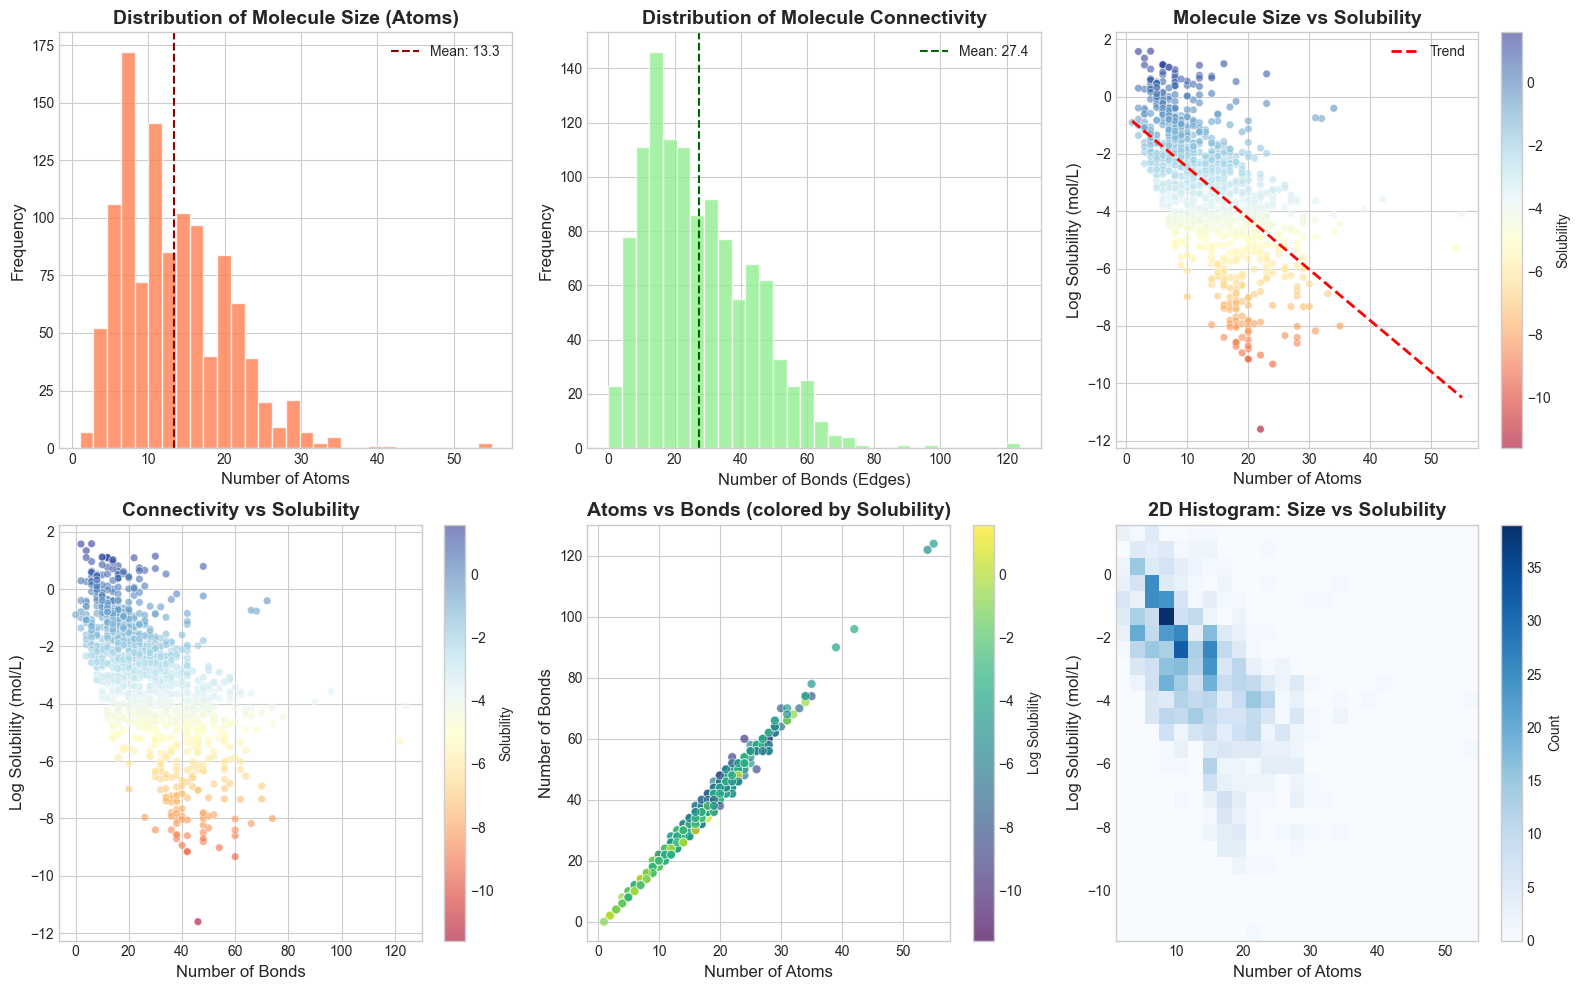

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribution  Number of Atoms
ax1 = axes[0, 0]
ax1.hist(df['Num Atoms'], bins=30, color='coral', edgecolor='white', alpha=0.8)
ax1.set_xlabel('Number of Atoms', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Molecule Size (Atoms)', fontsize=14, fontweight='bold')
ax1.axvline(df['Num Atoms'].mean(), color='darkred', linestyle='--', 
            label=f'Mean: {df["Num Atoms"].mean():.1f}')
ax1.legend()

# 2. Distribution  Number of Bonds
ax2 = axes[0, 1]
ax2.hist(df['Num Bonds'], bins=30, color='lightgreen', edgecolor='white', alpha=0.8)
ax2.set_xlabel('Number of Bonds (Edges)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Molecule Connectivity', fontsize=14, fontweight='bold')
ax2.axvline(df['Num Bonds'].mean(), color='darkgreen', linestyle='--', 
            label=f'Mean: {df["Num Bonds"].mean():.1f}')
ax2.legend()

# 3. Atoms vs Solubility
ax3 = axes[0, 2]
scatter = ax3.scatter(df['Num Atoms'], df['Solubility (log mol/L)'], 
                      c=df['Solubility (log mol/L)'], cmap='RdYlBu', 
                      alpha=0.6, s=30, edgecolors='white', linewidth=0.5)
ax3.set_xlabel('Number of Atoms', fontsize=12)
ax3.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax3.set_title('Molecule Size vs Solubility', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='Solubility')

# Adding a  trend line
z = np.polyfit(df['Num Atoms'], df['Solubility (log mol/L)'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['Num Atoms'].min(), df['Num Atoms'].max(), 100)
ax3.plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend')
ax3.legend()

# 4. Bonds vs Solubility
ax4 = axes[1, 0]
scatter2 = ax4.scatter(df['Num Bonds'], df['Solubility (log mol/L)'], 
                       c=df['Solubility (log mol/L)'], cmap='RdYlBu', 
                       alpha=0.6, s=30, edgecolors='white', linewidth=0.5)
ax4.set_xlabel('Number of Bonds', fontsize=12)
ax4.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax4.set_title('Connectivity vs Solubility', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax4, label='Solubility')

# 5. Atoms vs Bonds (They are colored by solubility)
ax5 = axes[1, 1]
scatter3 = ax5.scatter(df['Num Atoms'], df['Num Bonds'], 
                       c=df['Solubility (log mol/L)'], cmap='viridis', 
                       alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
ax5.set_xlabel('Number of Atoms', fontsize=12)
ax5.set_ylabel('Number of Bonds', fontsize=12)
ax5.set_title('Atoms vs Bonds (colored by Solubility)', fontsize=14, fontweight='bold')
plt.colorbar(scatter3, ax=ax5, label='Log Solubility')

# 6. 2D Density Plot
ax6 = axes[1, 2]
h = ax6.hist2d(df['Num Atoms'], df['Solubility (log mol/L)'], bins=25, cmap='Blues')
ax6.set_xlabel('Number of Atoms', fontsize=12)
ax6.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax6.set_title('2D Histogram: Size vs Solubility', fontsize=14, fontweight='bold')
plt.colorbar(h[3], ax=ax6, label='Count')

plt.tight_layout()
plt.savefig('esol_graph_structure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


NODE FEATURE ANALYSIS
Total number of atoms across all molecules: 14991
Number of node features: 9

Node Feature Statistics:
          Feature_0  Feature_1     Feature_2     Feature_3     Feature_4  \
count  14991.000000    14991.0  14991.000000  14991.000000  14991.000000   
mean       7.127343        0.0      2.987392      5.000000      0.929091   
std        3.546074        0.0      0.937849      0.102666      0.991479   
min        6.000000        0.0      1.000000      4.000000      0.000000   
25%        6.000000        0.0      3.000000      5.000000      0.000000   
50%        6.000000        0.0      3.000000      5.000000      1.000000   
75%        7.000000        0.0      4.000000      5.000000      1.000000   
max       53.000000        0.0      4.000000      6.000000      4.000000   

       Feature_5     Feature_6     Feature_7     Feature_8  
count    14991.0  14991.000000  14991.000000  14991.000000  
mean         0.0      3.400374      0.390501      0.538390  
std   

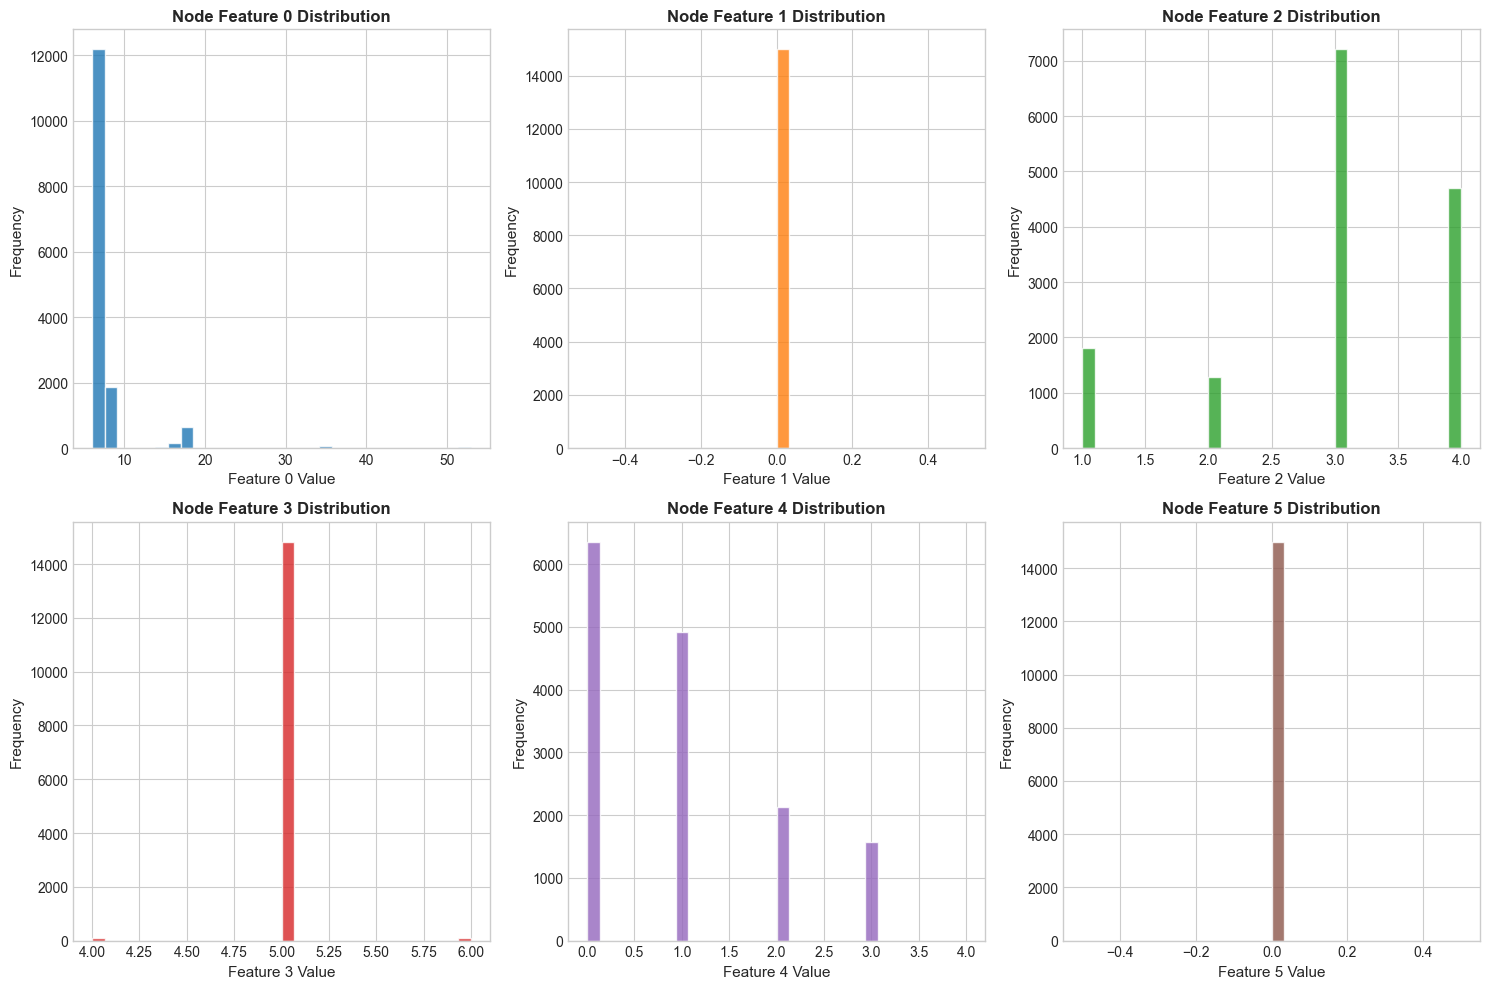

In [7]:
# Analyzing node features across all molecules
all_node_features = []
for mol in dataset:
    all_node_features.append(mol.x.numpy())

# Concatenating all node features
all_nodes = np.vstack(all_node_features)

print(f"\n{'='*50}")
print("NODE FEATURE ANALYSIS")
print(f"{'='*50}")
print(f"Total number of atoms across all molecules: {all_nodes.shape[0]}")
print(f"Number of node features: {all_nodes.shape[1]}")

# Feature statistics
node_df = pd.DataFrame(all_nodes, columns=[f'Feature_{i}' for i in range(all_nodes.shape[1])])
print(f"\nNode Feature Statistics:")
print(node_df.describe())

# Visualizing node features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(min(6, all_nodes.shape[1])):
    ax = axes[i // 3, i % 3]
    ax.hist(all_nodes[:, i], bins=30, color=plt.cm.tab10(i), edgecolor='white', alpha=0.8)
    ax.set_xlabel(f'Feature {i} Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Node Feature {i} Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('esol_node_features.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/kb/hg6zwpfn7wbfxvff4s4d08_h0000gn/T/ipykernel_5733/2968051952.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Category', y='Num Atoms', order=order,
/var/folders/kb/hg6zwpfn7wbfxvff4s4d08_h0000gn/T/ipykernel_5733/2968051952.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(order, rotation=45, ha='right')
/var/folders/kb/hg6zwpfn7wbfxvff4s4d08_h0000gn/T/ipykernel_5733/2968051952.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='Category', y='Num Bonds', order=order,
/var/folders/kb/hg6zwpfn7wbfxvff4s4d08_h0000gn/T/ipykernel_5733

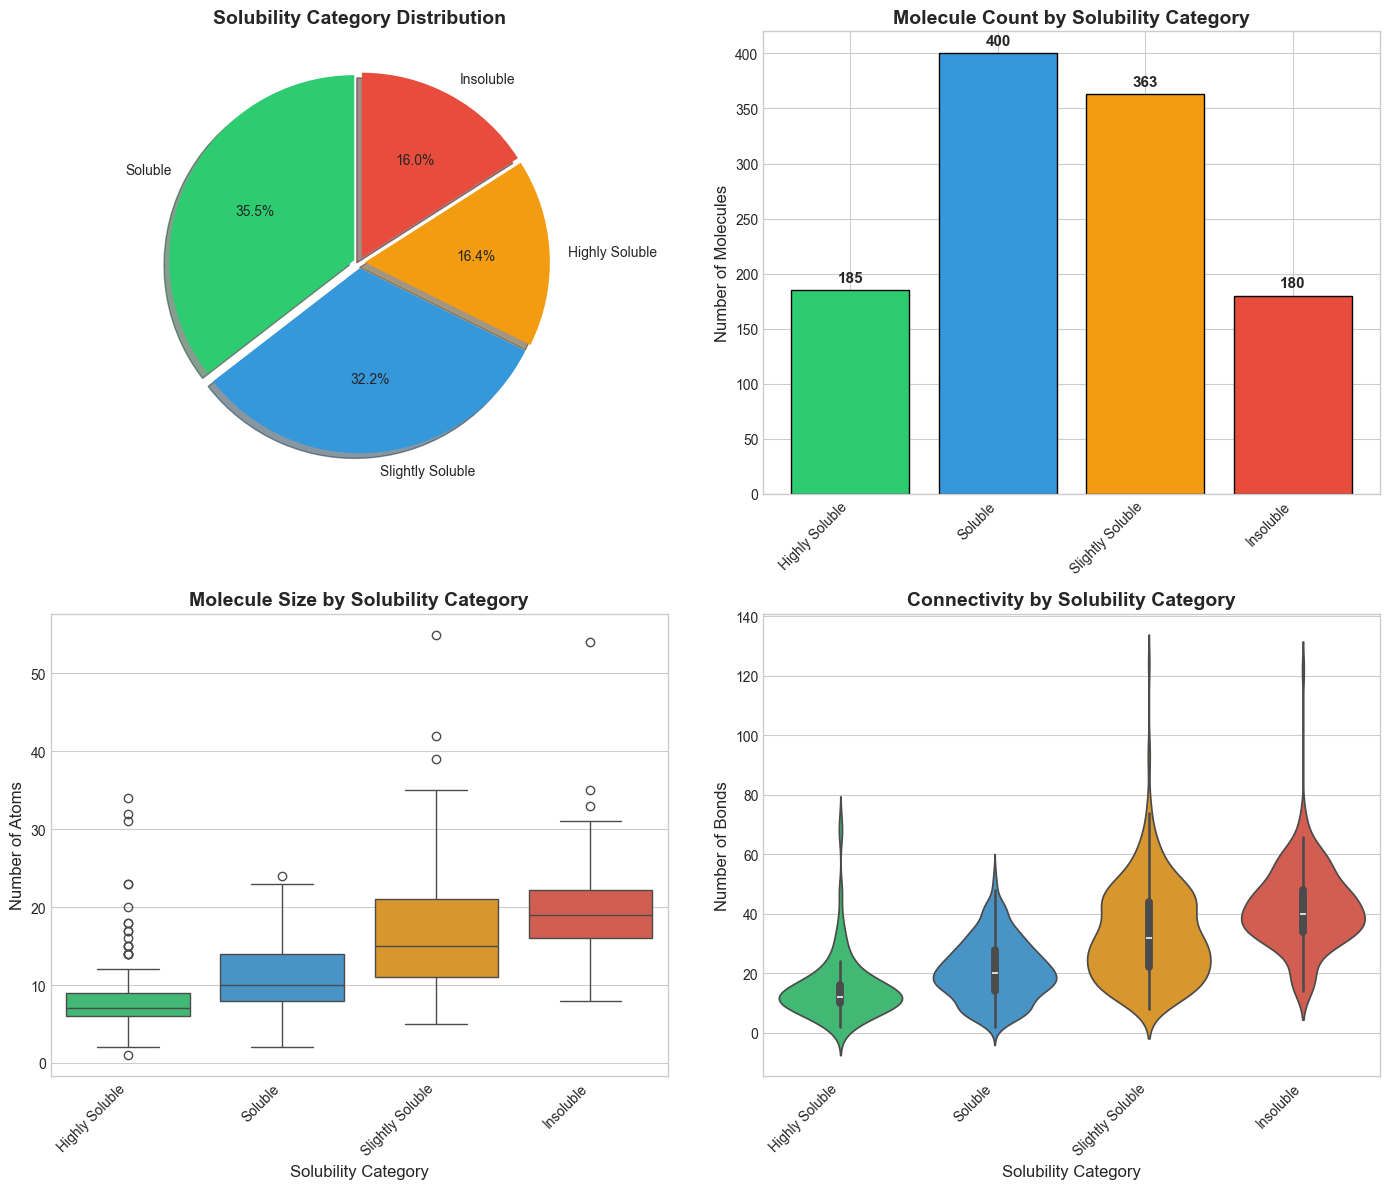


CATEGORY STATISTICS
                 Solubility (log mol/L)                         Num Atoms  \
                                  count  mean   std   min   max      mean   
Category                                                                    
Highly Soluble                      185 -0.16  0.64  -1.0  1.58      7.97   
Insoluble                           180 -6.52  1.20 -11.6 -5.03     19.46   
Slightly Soluble                    363 -3.91  0.57  -5.0 -3.01     15.94   
Soluble                             400 -2.05  0.54  -3.0 -1.01     10.57   

                       Num Bonds         
                   std      mean    std  
Category                                 
Highly Soluble    4.81     14.99  10.64  
Insoluble         5.93     41.84  13.52  
Slightly Soluble  6.93     33.47  16.07  
Soluble           4.42     21.00  10.07  


In [8]:

def categorize_solubility(log_s):
    if log_s >= -1:
        return 'Highly Soluble'
    elif log_s >= -3:
        return 'Soluble'
    elif log_s >= -5:
        return 'Slightly Soluble'
    else:
        return 'Insoluble'

df['Category'] = df['Solubility (log mol/L)'].apply(categorize_solubility)


fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. pai chart
ax1 = axes[0, 0]
category_counts = df['Category'].value_counts()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
explode = [0.03] * len(category_counts)
wedges, texts, autotexts = ax1.pie(category_counts.values, 
                                    labels=category_counts.index,
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    explode=explode,
                                    shadow=True,
                                    startangle=90)
ax1.set_title('Solubility Category Distribution', fontsize=14, fontweight='bold')

# 2.Mking a barchat with counts
ax2 = axes[0, 1]
order = ['Highly Soluble', 'Soluble', 'Slightly Soluble', 'Insoluble']
category_counts_ordered = df['Category'].value_counts().reindex(order).fillna(0)
bars = ax2.bar(range(len(order)), category_counts_ordered.values, color=colors, edgecolor='black')
ax2.set_xticks(range(len(order)))
ax2.set_xticklabels(order, rotation=45, ha='right')
ax2.set_ylabel('Number of Molecules', fontsize=12)
ax2.set_title('Molecule Count by Solubility Category', fontsize=14, fontweight='bold')

# Adding value labels on the bars
for bar, val in zip(bars, category_counts_ordered.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{int(val)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Box plot: Atoms by Category
ax3 = axes[1, 0]
df_plot = df[df['Category'].isin(order)]
sns.boxplot(data=df_plot, x='Category', y='Num Atoms', order=order, 
            palette=colors, ax=ax3)
ax3.set_xticklabels(order, rotation=45, ha='right')
ax3.set_xlabel('Solubility Category', fontsize=12)
ax3.set_ylabel('Number of Atoms', fontsize=12)
ax3.set_title('Molecule Size by Solubility Category', fontsize=14, fontweight='bold')

# 4. Violin plot: Bonds by Category (Don't know what this does , but someone suggested)
#A violin plot is a data-visualization used to show the distribution of a numeric variable, combining features of a box plot and a density plot. (For Reference)
ax4 = axes[1, 1]
sns.violinplot(data=df_plot, x='Category', y='Num Bonds', order=order, 
               palette=colors, ax=ax4)
ax4.set_xticklabels(order, rotation=45, ha='right')
ax4.set_xlabel('Solubility Category', fontsize=12)
ax4.set_ylabel('Number of Bonds', fontsize=12)
ax4.set_title('Connectivity by Solubility Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('esol_category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Printing Category Statistics of the data
print(f"\n{'='*50}")
print("CATEGORY STATISTICS")
print(f"{'='*50}")
print(df.groupby('Category').agg({
    'Solubility (log mol/L)': ['count', 'mean', 'std', 'min', 'max'],
    'Num Atoms': ['mean', 'std'],
    'Num Bonds': ['mean', 'std']
}).round(2))

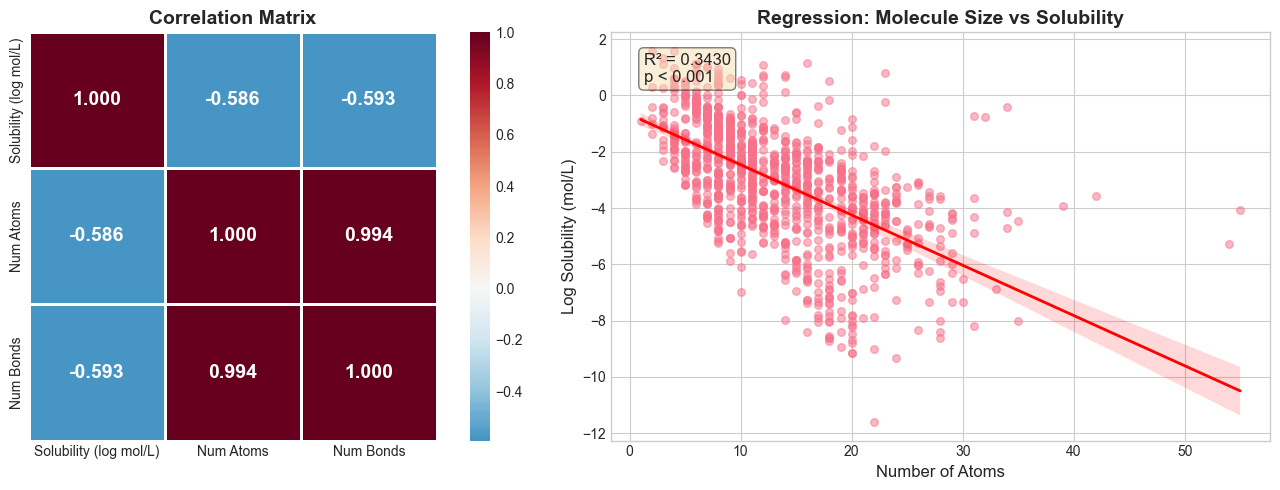


Correlation Analysis:
Correlation (Atoms vs Solubility): -0.5856
Correlation (Bonds vs Solubility): -0.5933


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Heatmap of correlation between data
ax1 = axes[0]
corr_matrix = df[['Solubility (log mol/L)', 'Num Atoms', 'Num Bonds']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', square=True, linewidths=1, ax=ax1,
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

# Regression Plot
ax2 = axes[1]
sns.regplot(data=df, x='Num Atoms', y='Solubility (log mol/L)', 
            scatter_kws={'alpha': 0.5, 's': 30}, 
            line_kws={'color': 'red', 'linewidth': 2},
            ax=ax2)
ax2.set_xlabel('Number of Atoms', fontsize=12)
ax2.set_ylabel('Log Solubility (mol/L)', fontsize=12)
ax2.set_title('Regression: Molecule Size vs Solubility', fontsize=14, fontweight='bold')

# Calculating  and displaying the  R² metric
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Num Atoms'], 
                                                                  df['Solubility (log mol/L)'])
ax2.text(0.05, 0.95, f'R² = {r_value**2:.4f}\np < 0.001', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('esol_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCorrelation Analysis:")
print(f"Correlation (Atoms vs Solubility): {corr_matrix.loc['Num Atoms', 'Solubility (log mol/L)']:.4f}")
print(f"Correlation (Bonds vs Solubility): {corr_matrix.loc['Num Bonds', 'Solubility (log mol/L)']:.4f}")


EDGE FEATURE ANALYSIS
Total number of edges: 30856
Number of edge features: 3


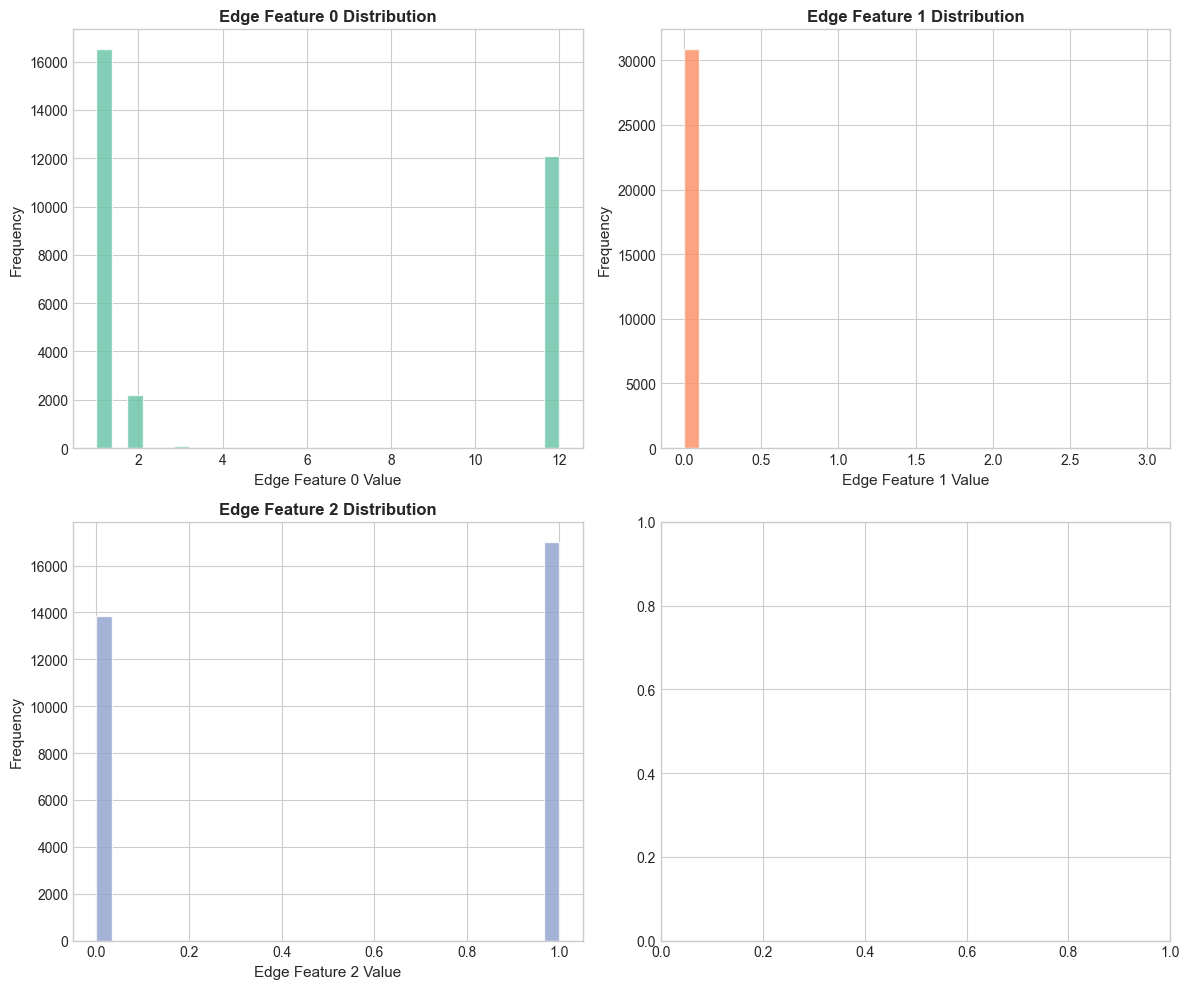

In [10]:
# EDGE FEATURE ANALYSIS
print(f"\n{'='*50}")
print("EDGE FEATURE ANALYSIS")
print(f"{'='*50}")

all_edge_features = []
for mol in dataset:
    if mol.edge_attr is not None:
        all_edge_features.append(mol.edge_attr.numpy())

if all_edge_features:
    all_edges = np.vstack(all_edge_features)
    print(f"Total number of edges: {all_edges.shape[0]}")
    print(f"Number of edge features: {all_edges.shape[1]}")
    
    # Visualize edge features
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    for i in range(min(4, all_edges.shape[1])):
        ax = axes[i // 2, i % 2]
        ax.hist(all_edges[:, i], bins=30, color=plt.cm.Set2(i), edgecolor='white', alpha=0.8)
        ax.set_xlabel(f'Edge Feature {i} Value', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Edge Feature {i} Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('esol_edge_features.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No edge features available in this dataset.")

In [11]:
print(f"\n{'='*50}")
print("DATALOADER FOR GRAPH NEURAL NETWORKS")
print(f"{'='*50}")

# For creating a test / train split.
from torch_geometric.loader import DataLoader
import random

# shuffling and splitting the dataset.
indices = list(range(len(dataset)))
random.seed(42)
random.shuffle(indices)

train_size = int(0.8 * len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = dataset[torch.tensor(train_indices)]
test_dataset = dataset[torch.tensor(test_indices)]

print(f"Training set size: {len(train_indices)}")
print(f"Test set size: {len(test_indices)}")

# Sample Dataloader creation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Showing the  batch structures
for batch in train_loader:
    print(f"\nBatch Structure:")
    print(f"  Batch object: {batch}")
    print(f"  Batch node features shape: {batch.x.shape}")
    print(f"  Batch edge index shape: {batch.edge_index.shape}")
    print(f"  Batch targets shape: {batch.y.shape}")
    print(f"  Batch vector (graph assignment): {batch.batch.shape}")
    print(f"  Number of graphs in batch: {batch.num_graphs}")
    break


DATALOADER FOR GRAPH NEURAL NETWORKS
Training set size: 902
Test set size: 226

Batch Structure:
  Batch object: DataBatch(x=[412, 9], edge_index=[2, 834], edge_attr=[834, 3], smiles=[32], y=[32, 1], batch=[412], ptr=[33])
  Batch node features shape: torch.Size([412, 9])
  Batch edge index shape: torch.Size([2, 834])
  Batch targets shape: torch.Size([32, 1])
  Batch vector (graph assignment): torch.Size([412])
  Number of graphs in batch: 32


In [12]:
print(f"\n{'='*60}")
print("COMPREHENSIVE ESOL DATASET SUMMARY")
print(f"{'='*60}")

summary = f"""
 DATASET INFORMATION:
   • Total Molecules: {len(dataset)}
   • Node Features: {dataset.num_node_features}
   • Edge Features: {dataset.num_edge_features}

 SOLUBILITY STATISTICS:
   • Mean: {df['Solubility (log mol/L)'].mean():.4f} log(mol/L)
   • Std Dev: {df['Solubility (log mol/L)'].std():.4f}
   • Min: {df['Solubility (log mol/L)'].min():.4f} log(mol/L)
   • Max: {df['Solubility (log mol/L)'].max():.4f} log(mol/L)
   • Range: {df['Solubility (log mol/L)'].max() - df['Solubility (log mol/L)'].min():.4f}

 MOLECULAR STRUCTURE:
   • Avg Atoms per Molecule: {df['Num Atoms'].mean():.1f} ± {df['Num Atoms'].std():.1f}
   • Avg Bonds per Molecule: {df['Num Bonds'].mean():.1f} ± {df['Num Bonds'].std():.1f}
   • Smallest Molecule: {df['Num Atoms'].min()} atoms
   • Largest Molecule: {df['Num Atoms'].max()} atoms

CORRELATIONS:
   • Atoms vs Solubility: {corr_matrix.loc['Num Atoms', 'Solubility (log mol/L)']:.4f}
   • Bonds vs Solubility: {corr_matrix.loc['Num Bonds', 'Solubility (log mol/L)']:.4f}

️SOLUBILITY CATEGORIES:
"""

for cat in ['Highly Soluble', 'Soluble', 'Slightly Soluble', 'Insoluble']:
    count = len(df[df['Category'] == cat])
    pct = count / len(df) * 100
    summary += f"   • {cat}: {count} molecules ({pct:.1f}%)\n"

print(summary)

print(f"""
 KEY INSIGHTS:
   1. Larger molecules (more atoms) tend to be less soluble
   2. Most molecules fall in the 'Soluble' to 'Slightly Soluble' range
   3. Strong negative correlation between molecular size and solubility
   4. The dataset is well-balanced for machine learning tasks
""")


COMPREHENSIVE ESOL DATASET SUMMARY

 DATASET INFORMATION:
   • Total Molecules: 1128
   • Node Features: 9
   • Edge Features: 3

 SOLUBILITY STATISTICS:
   • Mean: -3.0501 log(mol/L)
   • Std Dev: 2.0964
   • Min: -11.6000 log(mol/L)
   • Max: 1.5800 log(mol/L)
   • Range: 13.1800

 MOLECULAR STRUCTURE:
   • Avg Atoms per Molecule: 13.3 ± 6.9
   • Avg Bonds per Molecule: 27.4 ± 15.9
   • Smallest Molecule: 1 atoms
   • Largest Molecule: 55 atoms

CORRELATIONS:
   • Atoms vs Solubility: -0.5856
   • Bonds vs Solubility: -0.5933

️SOLUBILITY CATEGORIES:
   • Highly Soluble: 185 molecules (16.4%)
   • Soluble: 400 molecules (35.5%)
   • Slightly Soluble: 363 molecules (32.2%)
   • Insoluble: 180 molecules (16.0%)


 KEY INSIGHTS:
   1. Larger molecules (more atoms) tend to be less soluble
   2. Most molecules fall in the 'Soluble' to 'Slightly Soluble' range
   3. Strong negative correlation between molecular size and solubility
   4. The dataset is well-balanced for machine learning ta